In [ ]:
#!pip install -q kaggle
#!pip install phik -q
!pip install catboost -q
!pip install shap -q
#!pip install ipywidgets -q


competition here 

Соревнование находится здесь

https://www.kaggle.com/competitions/yapr1-hackaton

The purpose of this competition is to develop a model of propensity (binary classification) for a client to purchase equipment after communicating with him in one of the channels

Цель этого соревнования - разработка модели склонности (бинарной классификации) к покупке клиентом оборудования после коммуникации с ним в одном из каналов

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/Peton/hakaton_r1/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c yapr1-hackaton

yapr1-hackaton.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir yapr1_hackaton

mkdir: cannot create directory ‘yapr1_hackaton’: File exists


In [ ]:
!unzip -n yapr1-hackaton.zip -d yapr1_hackaton

Archive:  yapr1-hackaton.zip


In [ ]:
!cp /content/drive/MyDrive/Peton/hakaton_r1/third_features_list_categorical_int.json yapr1_hackaton/
!cp /content/drive/MyDrive/Peton/hakaton_r1/third_features_list_categorical_str.json yapr1_hackaton/
!cp /content/drive/MyDrive/Peton/hakaton_r1/third_features_list_numeric.json yapr1_hackaton/
!cp /content/drive/MyDrive/Peton/hakaton_r1/third_features_list.json yapr1_hackaton/

In [ ]:
import pandas as pd
import numpy as np
import os
import json
from matplotlib import pyplot as plt
import seaborn as sns
#import phik
from scipy.stats import kstest

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.utils import shuffle

from catboost import CatBoostClassifier


from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [ ]:
#константы
#constants
STATE = 12345

#Путь к каталогу с данными
#path to data
DATA_PATH = 'yapr1_hackaton/'
DATA_PATH_GOOGLE = '/content/drive/MyDrive/Peton/hakaton_r1/'

In [ ]:
#прочитаем данные sample_submission
#read data `sample_submission`
patch = os.path.join(DATA_PATH, 'sample_submission.csv')

sample_submission = pd.read_csv(patch)
sample_submission.head()

,id,target
0,0,0.343518
1,1,0.591216
2,2,0.913150
3,3,0.560035
4,4,0.352795


In [ ]:
sample_submission.shape

(60661, 2)

In [ ]:
#прочитаем данные features_types.json
#read data `features_types.json`
patch = os.path.join(DATA_PATH, 'features_types.json')

#открываем JSON файл
f = open(patch)

#возвращаем JSON обьект как словарь
data_json = json.load(f)

#закрытие файла
f.close()


In [ ]:
#распределение столбцов по типу данных
pd.DataFrame(data_json.values()).value_counts()

numeric            2607
categorical_int     138
categorical_str      31
dtype: int64

In [ ]:
#вывести все ключи словаря с значением 'categorical_str в значении

json_cat_str = [i for i in data_json if data_json[i]=="categorical_str"]
#json_cat_str

#вывести все ключи словаря с значением 'categorical_int в значении
json_cat_int = [i for i in data_json if data_json[i]=="categorical_int"]
#json_cat_int

json_cat = json_cat_str + json_cat_int
len(json_cat)

169

#### Чтение тестовой выборки

#### read test data 

In [ ]:
#прочитаем данные dataset_train.parquet
#только столбец id
patch = os.path.join(DATA_PATH, 'features_oot.parquet')

features_oot = pd.read_parquet(patch, engine='auto', columns=['id', 'channel_name'])
features_oot.head(5)

,id,channel_name
0,1548227,3
1,1173554,3
2,1370450,3
3,1254949,3
4,1549365,3


In [ ]:
features_oot.shape

(60661, 2)

In [ ]:
features_oot['channel_name'].unique()

array(['3'], dtype=object)

In [ ]:
features_oot['id'].value_counts()[:5]

1500152    4
1593490    3
1678519    3
1076751    3
1578084    3
Name: id, dtype: int64

так же, встречаются повторяющиеся id

## Работа с first_second_features_list_numeric_filter партией признаков

(как решили в команде)

In [ ]:
#прочитаем данные first_second_features_list_numeric_filter.json
patch = os.path.join(DATA_PATH_GOOGLE, 'first_second_features_list_numeric_filter.json')

#открываем JSON файл
f = open(patch)

#возвращаем JSON обьект как словарь
first_second_features_list_numeric_filter = json.load(f)

#закрытие файла
f.close()


In [ ]:
len(first_second_features_list_numeric_filter)

528

In [ ]:
#прочитаем данные dataset_train.parquet
#ВНИМАНИЕ читаются только столбцы где уровень пропусков менее 10%

patch = os.path.join(DATA_PATH_GOOGLE, 'columns_10_procent.csv')
columns_10_procent = pd.read_csv(patch)

cols_10_proc =  list(columns_10_procent['col_filtr']) + json_cat

patch = os.path.join(DATA_PATH, 'dataset_train.parquet')

dataset_train_third = pd.read_parquet(patch, engine='auto', columns=cols_10_proc)
dataset_train_third.head(3)

,id,period,channel_name,campaigns_388_1_part,spas_symptoms_int_35_1_cnt,payments_details_1_3_cnt,campaigns_347_3d6_part,user_devices_15_1_cnt,spas_symptoms_int_151_1_cnt,campaigns_391_1d6_part,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
0,1702673,202208,5,-1.434808,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-1.207983,...,-1,-1,0,-1,-1,-1,-1,1,-1,1
1,1177940,202210,5,-0.850342,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,1.573472,...,-1,-1,0,-1,-1,-1,-1,0,-1,1
2,1212244,202210,5,0.643293,-0.003594,-0.582865,1.759932,-0.001046,-0.025047,0.476915,...,-1,-1,0,1,0,0,0,0,-1,1


In [ ]:
dataset_train_third.shape

(702086, 449)

Начиная с уровня пропусков 5% количество столбцов резко падает с 900 до 170 примерно.

Поступлю таким образом.

1. Выбрать уровень пропусков 10%
2. Эти столбцы удалить из датасета
3. Пропуски в оставшихся заполнить или медианой или средним

In [ ]:
#распределение целевого признака
dataset_train_third.target.value_counts()

0    696617
1      5469
Name: target, dtype: int64

### Подготовка датасета трайн
### Preparation of the train dataset

In [ ]:
dataset_train_third['channel_name'] = dataset_train_third['channel_name'].astype('int8')

In [ ]:
dataset_train_third['period'] = pd.to_datetime(dataset_train_third['period'], format='%Y%m')

In [ ]:
dataset_train_third['period'] = dataset_train_third['period'].dt.month

In [ ]:
dataset_train_third.head(2)

,id,period,channel_name,campaigns_388_1_part,spas_symptoms_int_35_1_cnt,payments_details_1_3_cnt,campaigns_347_3d6_part,user_devices_15_1_cnt,spas_symptoms_int_151_1_cnt,campaigns_391_1d6_part,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
0,1702673,8,5,-1.434808,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-1.207983,...,-1,-1,0,-1,-1,-1,-1,1,-1,1
1,1177940,10,5,-0.850342,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,1.573472,...,-1,-1,0,-1,-1,-1,-1,0,-1,1


### Использование другого разделителя, с учетом групп (id)
### Using a different separator, taking into account groups (id)

In [ ]:
'''
features_id = dataset_train_third.drop(['target', 'id'], axis=1)
target_id = dataset_train_third['target']
features_id.shape, target_id.shape
'''

"\nfeatures_id = dataset_train_third.drop(['target', 'id'], axis=1)\ntarget_id = dataset_train_third['target']\nfeatures_id.shape, target_id.shape\n"

In [ ]:

features_id = dataset_train_third.drop(['target'], axis=1)
target_id = dataset_train_third['target']
features_id.shape, target_id.shape


((702086, 448), (702086,))

In [ ]:

#на валидацию 10%
n_splits = len(features_id['id'].unique())
gs = GroupShuffleSplit(n_splits=n_splits, train_size=.9, random_state=STATE)


In [ ]:

train_ix, valid_ix = next(gs.split(features_id, target_id, groups=features_id['id']))

x_train = features_id.loc[train_ix]
y_train = target_id.loc[train_ix]

x_valid = features_id.loc[valid_ix]
y_valid = target_id.loc[valid_ix]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape


((631760, 448), (631760,), (70326, 448), (70326,))

In [ ]:
y_train.mean(), y_valid.mean()

(0.007762441433455743, 0.008034013025054744)

In [ ]:
#проверка что ни один id не встречается в двух выборках одновременно
x_train.id.isin(x_valid.id).sum()

0

In [ ]:

x_train = x_train.drop(['id'], axis=1)
x_valid = x_valid.drop(['id'], axis=1)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape


((631760, 447), (631760,), (70326, 447), (70326,))

In [ ]:
y_train.value_counts()

0    626856
1      4904
Name: target, dtype: int64

### Использование простого разделителя
### Using a simple separator


In [ ]:
'''
#разделение на тренировочную и валидационную выборки
x_train, x_valid, y_train, y_valid = train_test_split(
    features_id,
    target_id,
    test_size=0.1,
    stratify=target_id,
    random_state=STATE)
'''

'\n#разделение на тренировочную и валидационную выборки\nx_train, x_valid, y_train, y_valid = train_test_split(\n    features_id,\n    target_id,\n    test_size=0.1,\n    stratify=target_id,\n    random_state=STATE)\n'

In [ ]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((631760, 447), (70326, 447), (631760,), (70326,))

In [ ]:
x_train.head(2)

,period,channel_name,campaigns_388_1_part,spas_symptoms_int_35_1_cnt,payments_details_1_3_cnt,campaigns_347_3d6_part,user_devices_15_1_cnt,spas_symptoms_int_151_1_cnt,campaigns_391_1d6_part,user_devices_29_1_cnt,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
1,10,5,-0.850342,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,1.573472,-0.170936,...,-1,-1,0,-1,-1,-1,-1,0,-1,1
2,10,5,0.643293,-0.003594,-0.582865,1.759932,-0.001046,-0.025047,0.476915,-0.170936,...,-1,-1,0,1,0,0,0,0,-1,1


(downsampling)


In [ ]:
#Функция для уменьшение количества обьектов

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=STATE)] + [features_ones])

    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=STATE)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=STATE)


    return features_downsampled, target_downsampled

In [ ]:
#уменьшение обьектов частого класса примерно в 127 раз
coeff = y_train.value_counts()[1] / y_train.value_counts()[0]
#coeff = 1 / 20

x_train_down, y_train_down = downsample(x_train, y_train, coeff)

In [ ]:
x_train_down.shape, y_train_down.shape, x_valid.shape, y_valid.shape

((9808, 447), (9808,), (70326, 447), (70326,))

In [ ]:
y_train_down.mean(), y_valid.mean()

(0.5, 0.008034013025054744)

In [ ]:
x_train_down.head(2)

,period,channel_name,campaigns_388_1_part,spas_symptoms_int_35_1_cnt,payments_details_1_3_cnt,campaigns_347_3d6_part,user_devices_15_1_cnt,spas_symptoms_int_151_1_cnt,campaigns_391_1d6_part,user_devices_29_1_cnt,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
682736,8,5,-1.434808,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-1.207983,-0.170936,...,-1,-1,0,-1,-1,-1,-1,0,-1,1
4741,3,3,-1.434808,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-1.207983,-0.170936,...,-1,-1,0,-1,-1,-1,-1,1,-1,1


Заполнение пропусков в числовых признаках

In [ ]:
#столбцы с пропусками
cols_pass = dataset_train_third.columns[dataset_train_third.isna().sum() > 0]
cols_pass

Index(['campaigns_388_1_part', 'spas_symptoms_int_35_1_cnt',
       'payments_details_1_3_cnt', 'campaigns_347_3d6_part',
       'spas_symptoms_int_151_1_cnt', 'campaigns_391_1d6_part',
       'spas_symptoms_int_15_1_cnt', 'campaigns_342_1_sum',
       'traffic_details_31_1_std', 'spas_symptoms_ott_23_1_cnt',
       ...
       'campaigns_172_1_sum', 'spas_symptoms_agr_111_3_std',
       'payments_details_40_3_sum', 'spas_symptoms_int_87_1_cnt',
       'spas_symptoms_int_16_1_cnt', 'spas_symptoms_int_12_1_cnt',
       'campaigns_191_1_sum', 'spas_symptoms_int_106_1_cnt',
       'spas_symptoms_agr_162_6_std', 'spas_symptoms_ott_89_1_cnt'],
      dtype='object', length=246)

In [ ]:
#так так столбцов слишком много, то использую более простой подход для заполнения
imp_mean = SimpleImputer(missing_values=np.nan,
                         #strategy='median',
                         strategy='mean'
                         )

In [ ]:
%%time
x_train_down[cols_pass] = imp_mean.fit_transform(x_train_down[cols_pass])

CPU times: user 786 ms, sys: 11.4 ms, total: 797 ms
Wall time: 1.1 s


In [ ]:
#проверка результата заполнения пропусков
x_train_down.isna().sum().max()

0

In [ ]:
%%time
x_valid[cols_pass] = imp_mean.transform(x_valid[cols_pass])

CPU times: user 4.54 s, sys: 4.4 s, total: 8.94 s
Wall time: 9.64 s


In [ ]:
#проверка результата заполнения пропусков
x_valid.isna().sum().max()

0

Пропусков в трейне и валидационной выборке нет.

In [ ]:
#функция для расчета ROC_AUC и построения графика ROC-кривая

def rock(features, target, model):
    #
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(target, probabilities_one_valid)

    print('ROC_AUC =', round(auc_roc, 4))

    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()

    plt.plot(fpr, tpr)

    #ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1.0], [0, 1.0], linestyle='--')

    #установка границ осей от 0 до 1
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])

    #подписи осей "False Positive Rate" и "True Positive Rate" >
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    #заголовок к графику "ROC-кривая"
    plt.title('ROC-кривая')
    plt.show()


### RandomForestClassifier

испытание на одной модели

In [ ]:
rf = RandomForestClassifier(n_estimators=80,
                            max_depth=32,
                            min_samples_split=2,
                            min_samples_leaf=4,
                            random_state=STATE,
                            #class_weight='balanced'
                            )

In [ ]:
%%time
rf.fit(x_train_down, y_train_down)

CPU times: user 3.83 s, sys: 30.6 ms, total: 3.86 s
Wall time: 3.87 s


RandomForestClassifier(max_depth=32, min_samples_leaf=4, n_estimators=80,
                       random_state=12345)

ROC_AUC = 0.7117


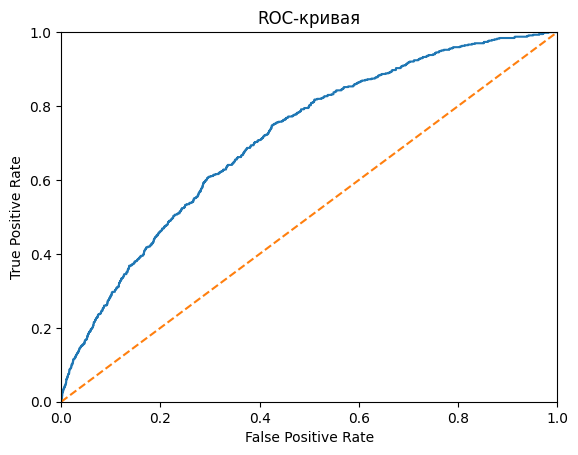

In [ ]:
#расчет ROC_AUC через вероятности классов и построение графика ROC - кривой
rock(x_valid, y_valid, rf)

In [ ]:
ROC_AUC = 0.7043
ROC_AUC = 0.7079 #1/20
ROC_AUC = 0.7128 #1/50
ROC_AUC = 0.7084 #1/100

ROC_AUC = 0.6636 #только 3й канал и простой разделитель

### Обучение CatBoost
### CatBoost training

In [ ]:
cb = CatBoostClassifier(iterations=300,
                        depth=6,
                        learning_rate=100.0e-3,
                        loss_function='Logloss',
                        random_seed=STATE,
                        eval_metric='AUC'
                           #verbose=True
                           )

In [ ]:
cb.fit(
    x_train_down, y_train_down,
    cat_features=json_cat,
    eval_set=(x_valid, y_valid),
    metric_period=10,
    verbose=True,
    plot=False
)

0:	test: 0.7090438	best: 0.7090438 (0)	total: 2.33s	remaining: 11m 36s
10:	test: 0.7330960	best: 0.7330960 (10)	total: 16.8s	remaining: 7m 21s
20:	test: 0.7377392	best: 0.7377392 (20)	total: 31.1s	remaining: 6m 53s
30:	test: 0.7385035	best: 0.7385035 (30)	total: 42.8s	remaining: 6m 11s
40:	test: 0.7380396	best: 0.7385035 (30)	total: 59s	remaining: 6m 12s
50:	test: 0.7401233	best: 0.7401233 (50)	total: 1m 13s	remaining: 5m 57s
60:	test: 0.7417095	best: 0.7417095 (60)	total: 1m 26s	remaining: 5m 40s
70:	test: 0.7423136	best: 0.7423136 (70)	total: 1m 42s	remaining: 5m 30s
80:	test: 0.7423743	best: 0.7423743 (80)	total: 1m 55s	remaining: 5m 13s
90:	test: 0.7429870	best: 0.7429870 (90)	total: 2m 10s	remaining: 4m 59s
100:	test: 0.7430682	best: 0.7430682 (100)	total: 2m 24s	remaining: 4m 44s
110:	test: 0.7435589	best: 0.7435589 (110)	total: 2m 38s	remaining: 4m 30s
120:	test: 0.7441222	best: 0.7441222 (120)	total: 2m 53s	remaining: 4m 15s
130:	test: 0.7441289	best: 0.7441289 (130)	total: 3m 

In [ ]:
bestTest = 0.7307966403 #штатное распределение
bestTest = 0. #1/20
bestTest = 0.7276619 #1/50
bestTest = 0.7289451 #1/100

bestTest = 0.744765015 #lr=0.1 depth=6 заполнение median

bestTest = 0.747303873 #lr=0.1 depth=6 заполнение mean

bestTest = 0.6783555065 #lr=0.1 depth=6 заполнение mean? только 3й канал и простой разделитель



ROC_AUC = 0.7473


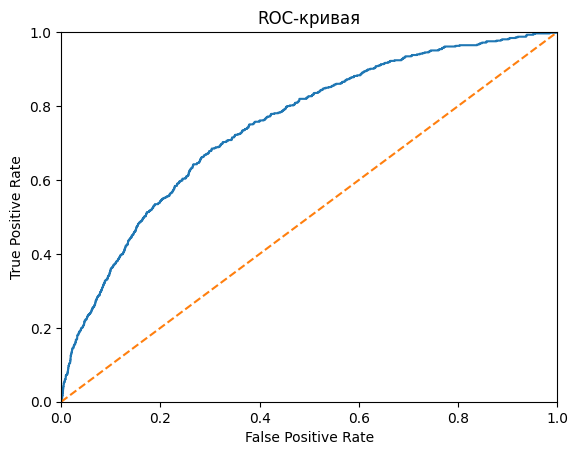

In [ ]:
#расчет ROC_AUC через вероятности классов и построение графика ROC - кривой
rock(x_valid, y_valid, cb)

In [ ]:
feature_imp = cb.get_feature_importance(prettified=True)
feature_imp

,Feature Id,Importances
0,channel_name,11.760250
1,basic_info_0_0_avg,2.816959
2,communication_availability_30_1_flg,2.060686
3,user_devices_24_1_cnt,1.731774
4,campaigns_283_3_part,1.485498
...,...,...
442,user_active_21_1_flg,0.000000
443,user_active_32_1_flg,0.000000
444,communication_availability_65_1_flg,0.000000
445,autopay_1_1_flg,0.000000


In [ ]:
feature_imp.query('Importances > 0.001')

,Feature Id,Importances
0,channel_name,11.760250
1,basic_info_0_0_avg,2.816959
2,communication_availability_30_1_flg,2.060686
3,user_devices_24_1_cnt,1.731774
4,campaigns_283_3_part,1.485498
...,...,...
285,spas_symptoms_agr_265_1_sum,0.005982
286,materials_details_23_1_flg,0.002621
287,campaigns_224_1_sum,0.002546
288,user_active_4_1_flg,0.002266


### Получение предсказаний на тестовой выборке
### Making predictions on a test sample

In [ ]:
#прочитаем данные features_oot.parquet
cols_10_proc =  list(columns_10_procent['col_filtr'])[:-1] + json_cat

patch = os.path.join(DATA_PATH, 'features_oot.parquet')

features_oot = pd.read_parquet(patch, engine='auto', columns=cols_10_proc)
features_oot.head(2)

,id,period,channel_name,campaigns_388_1_part,spas_symptoms_int_35_1_cnt,payments_details_1_3_cnt,campaigns_347_3d6_part,user_devices_15_1_cnt,spas_symptoms_int_151_1_cnt,campaigns_391_1d6_part,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
0,1548227,202303,3,-0.204353,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-0.11888,...,-1,-1,0,1,0,0,1,0,-1,1
1,1173554,202302,3,-0.355794,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-0.44130,...,-1,-1,0,-1,-1,-1,-1,0,-1,1


In [ ]:
features_oot = features_oot.drop('id', axis=1)
features_oot.head(1)

,period,channel_name,campaigns_388_1_part,spas_symptoms_int_35_1_cnt,payments_details_1_3_cnt,campaigns_347_3d6_part,user_devices_15_1_cnt,spas_symptoms_int_151_1_cnt,campaigns_391_1d6_part,user_devices_29_1_cnt,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
0,202303,3,-0.204353,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-0.11888,-0.170936,...,-1,-1,0,1,0,0,1,0,-1,1


In [ ]:
#проверка пропусков
features_oot.isna().sum().max()

1128

In [ ]:
#features_oot['channel_name'] = features_oot['channel_name'].astype('int8')
features_oot['period'] = pd.to_datetime(features_oot['period'], format='%Y%m')
features_oot['period'] = features_oot['period'].dt.month

In [ ]:
features_oot.head(2)

,period,channel_name,campaigns_388_1_part,spas_symptoms_int_35_1_cnt,payments_details_1_3_cnt,campaigns_347_3d6_part,user_devices_15_1_cnt,spas_symptoms_int_151_1_cnt,campaigns_391_1d6_part,user_devices_29_1_cnt,...,autopay_1_1_flg,autopay_3_1_flg,communication_availability_67_1_flg,social_dem_1_0_flg,social_dem_2_0_flg,social_dem_3_0_flg,social_dem_4_0_flg,user_active_35_1_flg,tariff_plans_26_src_id,communication_availability_69_1_flg
0,3,3,-0.204353,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-0.11888,-0.170936,...,-1,-1,0,1,0,0,1,0,-1,1
1,2,3,-0.355794,-0.003594,-0.582865,-0.615742,-0.001046,-0.025047,-0.44130,-0.170936,...,-1,-1,0,-1,-1,-1,-1,0,-1,1


In [ ]:
%%time
features_oot[cols_pass] = imp_mean.transform(features_oot[cols_pass])

CPU times: user 4.19 s, sys: 3.95 s, total: 8.14 s
Wall time: 8.24 s


In [ ]:
#проверка пропусков
features_oot.isna().sum().max()

0

In [ ]:
#получение предсказаний от модели

probabilities_valid_rf = rf.predict_proba(features_oot)
probabilities_valid_cb = cb.predict_proba(features_oot)

probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
probabilities_one_valid_cb = probabilities_valid_cb[:, 1]

In [ ]:
probabilities_one_valid_rf.max(), probabilities_one_valid_cb.max()

(0.9117929717542406, 0.9728765301888624)

In [ ]:
#чтение предсказаний Алексея
patch = os.path.join(DATA_PATH_GOOGLE, 'submition_xgb_ait_v4.csv')
alex_prob = pd.read_csv(patch)
alex_prob.head()

,id,target
0,0,0.275788
1,1,0.242277
2,2,0.501600
3,3,0.317302
4,4,0.489567


In [ ]:
proba_ansamble_alex_dron = (alex_prob['target'] + probabilities_one_valid_cb)/2

In [ ]:
proba_ansamble_alex_dron.max()

0.877353390718012

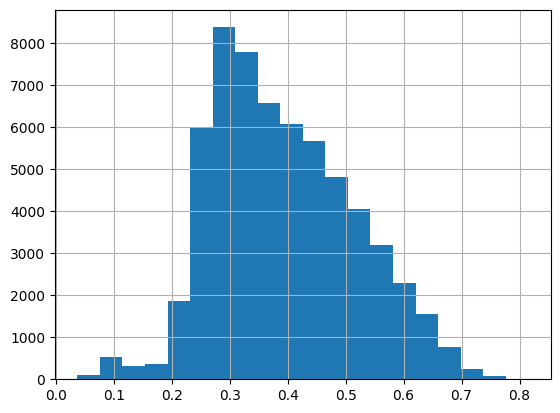

In [ ]:
alex_prob['target'].hist(bins=20);

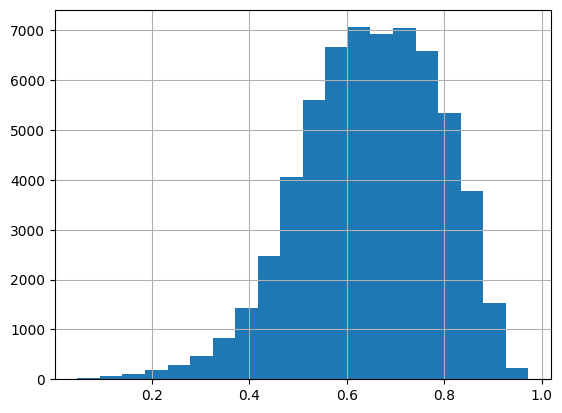

In [ ]:
pd.Series(probabilities_one_valid_cb).hist(bins=20);

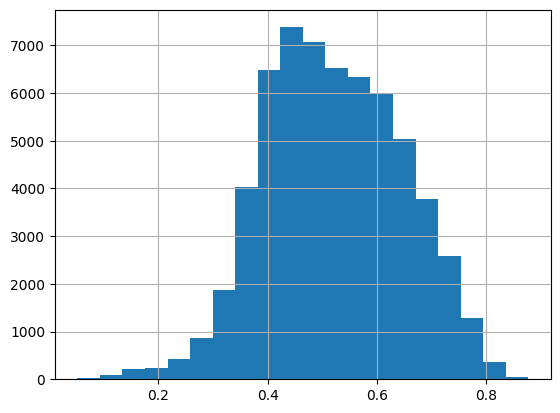

In [ ]:
proba_ansamble_alex_dron.hist(bins=20);

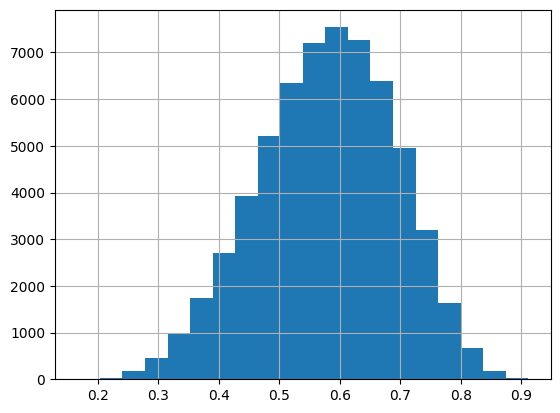

In [ ]:

pd.Series(probabilities_one_valid_rf).hist(bins=20);

In [ ]:
probabilities_ansamble = (probabilities_one_valid_rf + probabilities_one_valid_cb) / 2
len(probabilities_ansamble)

In [ ]:
#выходной файл для каггл

#sample_submission['target'] = probabilities_ansamble
#sample_submission['target'] = probabilities_one_valid
sample_submission['target'] = proba_ansamble_alex_dron
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60661 entries, 0 to 60660
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      60661 non-null  int64  
 1   target  60661 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 948.0 KB


In [ ]:
sample_submission.head(5)

,id,target
0,0,0.440481
1,1,0.398765
2,2,0.625885
3,3,0.516311
4,4,0.634910


In [ ]:
#сохранение результатов на диск
#save result to disk
DATA_PATH = '/content/drive/MyDrive/Peton/hakaton_r1/'
#patch = os.path.join(DATA_PATH, 'pred_out.csv')
patch = os.path.join(DATA_PATH, 'pred_out_ansamble.csv')
pd.DataFrame(sample_submission).to_csv(patch, index=False)

-- --
В этом соревновании наша команда (Super8) заняла 10-е место

Our team (Super8) took 10th place in this competition